In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)
train_dataset = dataset['train']



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.Q6AMLB_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [2]:
print(info)

tfds.core.DatasetInfo(
    name='plant_village',
    full_name='plant_village/1.0.2',
    description="""
    The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images
    divided into 38 categories by species and disease.
    
    NOTE: The original dataset is not available from the original source
    (plantvillage.org), therefore we get the unaugmented dataset from a paper that
    used that dataset and republished it. Moreover, we dropped images with
    Background_without_leaves label, because these were not present in the original
    dataset.
    
    Original paper URL: https://arxiv.org/abs/1511.08060 Dataset URL:
    https://data.mendeley.com/datasets/tywbtsjrjv/1
    """,
    homepage='https://arxiv.org/abs/1511.08060',
    data_dir='/root/tensorflow_datasets/plant_village/1.0.2',
    file_format=tfrecord,
    download_size=827.82 MiB,
    dataset_size=815.37 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
     

## check

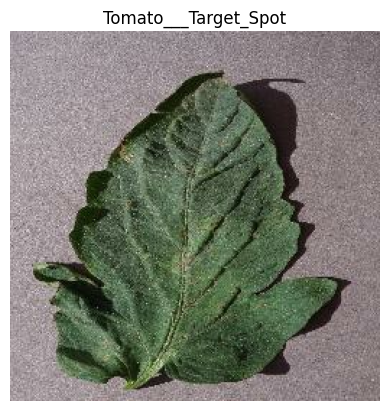

In [3]:
import matplotlib.pyplot as plt

for image, label in train_dataset.take(1):
    plt.imshow(image)
    plt.title(info.features['label'].int2str(label))
    plt.axis('off')
    plt.show()


In [4]:
print(info.features['label'].names)
print(len(info.features['label'].names))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___

## split data

In [5]:
TOTAL_IMAGES = info.splits['train'].num_examples
train_size = int(0.8 * TOTAL_IMAGES)             # 80% for training
val_size = TOTAL_IMAGES - train_size            # 20% for validation

train_dataset = train_dataset.take(train_size)
val_dataset = train_dataset.skip(train_size)


## pre processing

In [6]:
import tensorflow as tf

IMG_SIZE = 224

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # scale  to 0-1
    return image, label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)


In [7]:
# shuffle and batch
BATCH_SIZE = 32

train_dataset = train_dataset.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## model

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax')  # 38 classes
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
EPOCHS = 10
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS)


Epoch 1/10
 467/1358 ━━━━━━━━━━━━━━━━━━━━ 1:04 72ms/step - accuracy: 0.7118 - loss: 1.1395